# Shot Probability Model

Many factors affect the chances that a field goal attempt will be successful. While not exhaustive, the following list contains a few:

- Shooting ability of the shooter
- Proximity (and number) of the closest defender(s)
- Shot location
- Shot type

The following introduces the `Player` class of the [py_ball](https://github.com/basketballrelativity/py_ball) package by exploring the `shortchartdetail` and `playbyplay` endpoints of the [stats.nba.com](https://stats.nba.com). The goal of this analysis is to build a shot probability model that outperforms a baseline model.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
import itertools

from PIL import Image
import time
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from IPython.display import IFrame

from py_ball import player, playbyplay

HEADERS = {'Connection': 'close',
           'Host': 'stats.nba.com',
           'Origin': 'http://stats.nba.com',
           'Upgrade-Insecure-Requests': '1',
           'Referer': 'stats.nba.com',
           'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_2)' + \
                         'AppleWebKit/537.36 (KHTML, like Gecko) ' + \
                         'Chrome/66.0.3359.117 Safari/537.36'}

pd.options.mode.chained_assignment = None  # Disabling pandas SetWithCopyWarnings

The `shotchartdetail` endpoint accepts a variety of parameters, but only a few are relevant for shot probability purposes:
- league_id: '00' for the NBA, '10' for the WNBA
- player_id: The unique identifier for the player (0 returns shot data for the whole game)
- game_id: The unique identifier for the game of interest
- season: YYYY-ZZ season year format (This only affects the league averages returned)

In [5]:
league_id = '00' #NBA
player_id = '0' #All players
game_id = '1021900008'
season = '2019'

shots = player.Player(headers=HEADERS,
                      endpoint='shotchartdetail',
                      league_id=league_id,
                      player_id=player_id,
                      game_id=game_id,
                      season=season)
shot_df = pd.DataFrame(shots.data['Shot_Chart_Detail'])
shot_df.head(15)

""


In [13]:
shots.data['LeagueAverages']

[{'FGA': 8,
  'FGM': 0,
  'FG_PCT': 0.0,
  'GRID_TYPE': 'League Averages',
  'SHOT_ZONE_AREA': 'Back Court(BC)',
  'SHOT_ZONE_BASIC': 'Above the Break 3',
  'SHOT_ZONE_RANGE': 'Back Court Shot'},
 {'FGA': 681,
  'FGM': 207,
  'FG_PCT': 0.304,
  'GRID_TYPE': 'League Averages',
  'SHOT_ZONE_AREA': 'Center(C)',
  'SHOT_ZONE_BASIC': 'Above the Break 3',
  'SHOT_ZONE_RANGE': '24+ ft.'},
 {'FGA': 1333,
  'FGM': 433,
  'FG_PCT': 0.325,
  'GRID_TYPE': 'League Averages',
  'SHOT_ZONE_AREA': 'Left Side Center(LC)',
  'SHOT_ZONE_BASIC': 'Above the Break 3',
  'SHOT_ZONE_RANGE': '24+ ft.'},
 {'FGA': 1352,
  'FGM': 435,
  'FG_PCT': 0.322,
  'GRID_TYPE': 'League Averages',
  'SHOT_ZONE_AREA': 'Right Side Center(RC)',
  'SHOT_ZONE_BASIC': 'Above the Break 3',
  'SHOT_ZONE_RANGE': '24+ ft.'},
 {'FGA': 71,
  'FGM': 0,
  'FG_PCT': 0.0,
  'GRID_TYPE': 'League Averages',
  'SHOT_ZONE_AREA': 'Back Court(BC)',
  'SHOT_ZONE_BASIC': 'Backcourt',
  'SHOT_ZONE_RANGE': 'Back Court Shot'},
 {'FGA': 868,
  'FGM': 

Looks like the `shotchartdetail` endpoint has shot location (including zone and coordinates) and type. However, defender and shot clock information do not seem to be available. To calculate shooter ability, the `playerdashboardbyshootingsplits` endpoint may be of use.

In [4]:
shooters = player.Player(headers=HEADERS,
                         endpoint='playerdashboardbyshootingsplits',
                         league_id=league_id,
                         player_id='2772',
                         season=season)
shot_type_df = pd.DataFrame(shooters.data['ShotTypePlayerDashboard'])
shot_type_df.head(10)

,BLKA,BLKA_RANK,CFID,CFPARAMS,EFG_PCT,EFG_PCT_RANK,FG3A,FG3A_RANK,FG3M,FG3M_RANK,...,PCT_AST_3PM,PCT_AST_3PM_RANK,PCT_AST_FGM,PCT_AST_FGM_RANK,PCT_UAST_2PM,PCT_UAST_2PM_RANK,PCT_UAST_3PM,PCT_UAST_3PM_RANK,PCT_UAST_FGM,PCT_UAST_FGM_RANK
0,0,1,50,Alley Oop Dunk Shot,0.000,24,0,8,0,8,...,0.0,8,0.000,21,0.000,15,0.0,5,0.000,18
1,0,1,50,Alley Oop Layup shot,0.000,24,0,8,0,8,...,0.0,8,0.000,21,0.000,15,0.0,5,0.000,18
2,0,1,50,Cutting Dunk Shot,1.000,3,0,8,0,8,...,0.0,8,1.000,1,0.000,15,0.0,5,0.000,18
3,0,1,50,Cutting Finger Roll Layup Shot,0.000,24,0,8,0,8,...,0.0,8,0.000,21,0.000,15,0.0,5,0.000,18
4,2,40,50,Cutting Layup Shot,0.667,16,0,8,0,8,...,0.0,8,1.000,1,0.000,15,0.0,5,0.000,18
5,0,1,50,Driving Bank Hook Shot,0.000,24,0,8,0,8,...,0.0,8,0.000,21,0.000,15,0.0,5,0.000,18
6,0,1,50,Driving Dunk Shot,1.000,3,0,8,0,8,...,0.0,8,0.833,8,0.167,14,0.0,5,0.167,16
7,0,1,50,Driving Finger Roll Layup Shot,0.909,10,0,8,0,8,...,0.0,8,0.800,9,0.200,13,0.0,5,0.200,15
8,0,1,50,Driving Floating Bank Jump Shot,0.750,13,0,8,0,8,...,0.0,8,0.667,11,0.333,11,0.0,5,0.333,11
9,3,43,50,Driving Floating Jump Shot,0.250,23,0,8,0,8,...,0.0,8,0.500,15,0.500,9,0.0,5,0.500,7


In [5]:
list(shot_type_df)

['BLKA',
 'BLKA_RANK',
 'CFID',
 'CFPARAMS',
 'EFG_PCT',
 'EFG_PCT_RANK',
 'FG3A',
 'FG3A_RANK',
 'FG3M',
 'FG3M_RANK',
 'FG3_PCT',
 'FG3_PCT_RANK',
 'FGA',
 'FGA_RANK',
 'FGM',
 'FGM_RANK',
 'FG_PCT',
 'FG_PCT_RANK',
 'GROUP_SET',
 'GROUP_VALUE',
 'PCT_AST_2PM',
 'PCT_AST_2PM_RANK',
 'PCT_AST_3PM',
 'PCT_AST_3PM_RANK',
 'PCT_AST_FGM',
 'PCT_AST_FGM_RANK',
 'PCT_UAST_2PM',
 'PCT_UAST_2PM_RANK',
 'PCT_UAST_3PM',
 'PCT_UAST_3PM_RANK',
 'PCT_UAST_FGM',
 'PCT_UAST_FGM_RANK']

The `shot_type_df` has a `CFPARAMS` field which seems to correspond to `ACTION_TYPE` in `shot_df`.

In [6]:
list(set(shot_df['ACTION_TYPE']))

['Putback Dunk Shot',
 'Hook Shot',
 'Running Layup Shot',
 'Turnaround Fadeaway Bank Jump Shot',
 'Cutting Layup Shot',
 'Driving Finger Roll Layup Shot',
 'Step Back Jump shot',
 'Reverse Layup Shot',
 'Turnaround Fadeaway shot',
 'Jump Shot',
 'Tip Layup Shot',
 'Alley Oop Dunk Shot',
 'Driving Floating Jump Shot',
 'Pullup Jump shot',
 'Layup Shot',
 'Driving Reverse Layup Shot',
 'Driving Dunk Shot',
 'Cutting Dunk Shot',
 'Running Reverse Layup Shot',
 'Fadeaway Jump Shot',
 'Floating Jump shot',
 'Putback Layup Shot',
 'Turnaround Jump Shot',
 'Dunk Shot',
 'Driving Layup Shot']

In [7]:
list(set(shot_type_df['CFPARAMS']))

['Running Jump Shot',
 'Putback Dunk Shot',
 'Turnaround Hook Shot',
 'Hook Shot',
 'Driving Floating Bank Jump Shot',
 'Driving Bank Hook Shot',
 'Running Layup Shot',
 'Driving Hook Shot',
 'Driving Reverse Dunk Shot',
 'Running Alley Oop Layup Shot',
 'Turnaround Fadeaway Bank Jump Shot',
 'Cutting Layup Shot',
 'Driving Finger Roll Layup Shot',
 'Running Dunk Shot',
 'Hook Bank Shot',
 'Step Back Jump shot',
 'Reverse Layup Shot',
 'Turnaround Fadeaway shot',
 'Jump Shot',
 'Alley Oop Dunk Shot',
 'Tip Layup Shot',
 'Driving Floating Jump Shot',
 'Pullup Jump shot',
 'Step Back Bank Jump Shot',
 'Running Finger Roll Layup Shot',
 'Alley Oop Layup shot',
 'Turnaround Bank Hook Shot',
 'Running Alley Oop Dunk Shot',
 'Layup Shot',
 'Reverse Dunk Shot',
 'Finger Roll Layup Shot',
 'Driving Reverse Layup Shot',
 'Cutting Finger Roll Layup Shot',
 'Tip Dunk Shot',
 'Driving Dunk Shot',
 'Cutting Dunk Shot',
 'Running Reverse Layup Shot',
 'Fadeaway Jump Shot',
 'Floating Jump shot',
 'P

In [8]:
shot_area_df = pd.DataFrame(shooters.data['ShotAreaPlayerDashboard'])
shot_area_df.head(10)

,BLKA,BLKA_RANK,CFID,CFPARAMS,EFG_PCT,EFG_PCT_RANK,FG3A,FG3A_RANK,FG3M,FG3M_RANK,...,PCT_AST_3PM,PCT_AST_3PM_RANK,PCT_AST_FGM,PCT_AST_FGM_RANK,PCT_UAST_2PM,PCT_UAST_2PM_RANK,PCT_UAST_3PM,PCT_UAST_3PM_RANK,PCT_UAST_FGM,PCT_UAST_FGM_RANK
0,12,7,49,Restricted Area,0.608,3,0,6,0,4,...,0.00,4,0.602,4,0.398,3,0.00,2,0.398,3
1,8,6,49,In The Paint (Non-RA),0.148,5,0,6,0,4,...,0.00,4,0.500,5,0.500,2,0.00,2,0.500,2
2,0,1,49,Mid-Range,0.111,6,1,5,0,4,...,0.00,4,0.000,6,1.000,1,0.00,2,1.000,1
3,0,1,49,Left Corner 3,0.640,2,75,3,32,3,...,1.00,1,1.000,1,0.000,4,0.00,2,0.000,5
4,0,1,49,Right Corner 3,0.650,1,113,2,49,2,...,1.00,1,1.000,1,0.000,4,0.00,2,0.000,5
5,1,5,49,Above the Break 3,0.491,4,271,1,89,1,...,0.91,3,0.910,3,0.000,4,0.09,1,0.090,4
6,0,1,49,Backcourt,0.000,7,2,4,0,4,...,0.00,4,0.000,6,0.000,4,0.00,2,0.000,5


After observing some of the potential features available, this shot probability model will go forward with the following features:
   - Shot distance
   - Angle to basket (0 degrees is straight on, 45 degrees is baseline)
   - Side of basket
   - Action type
   
These features are available directly from the `shotchartdetail` endpoint, so the following cell contains a function to generate those features.

In [9]:
def feature_engineering(shotchart_df):
    """ feature_engineering calculates engineered
    features from the shotchart data

    @param shotchart_df (DataFrame): DataFrame containing
    shotchart data

    Returns:

        shotchart_df (DataFrame): DataFrame containing
        the engineered features
    """

    shotchart_df['ANGLE'] = abs(np.rad2deg(np.arctan2(shotchart_df['LOC_X'],
                                                      shotchart_df['LOC_Y'])))

    shotchart_df['SIDE'] = [1 if x >= 0 else 0 for x in shotchart_df['LOC_X']]

    shotchart_df['DUNK'] = [1 if 'Dunk' in x else 0 for x in shotchart_df['ACTION_TYPE']]
    shotchart_df['HOOK'] = [1 if 'Hook' in x else 0 for x in shotchart_df['ACTION_TYPE']]
    shotchart_df['LAYUP'] = [1 if 'Layup' in x else 0 for x in shotchart_df['ACTION_TYPE']]
    shotchart_df['JUMP'] = [1 if 'Jump' in x else 0 for x in shotchart_df['ACTION_TYPE']]

    shotchart_df = shotchart_df[['SHOT_DISTANCE', 'ANGLE', 'SIDE', 'DUNK', 'HOOK', 'LAYUP', 'JUMP', 'SHOT_MADE_FLAG']]

    return shotchart_df

In [10]:
shot_df = feature_engineering(shot_df)

In [11]:
shot_df

,SHOT_DISTANCE,ANGLE,SIDE,DUNK,HOOK,LAYUP,JUMP,SHOT_MADE_FLAG
0,27,56.251467,1,0,0,0,1,1
1,16,49.513988,1,0,0,0,1,0
2,24,40.902716,0,0,0,0,1,0
3,29,29.647232,1,0,0,0,1,0
4,2,78.310631,0,0,0,1,0,0
5,24,59.511060,0,0,0,0,1,0
6,24,75.629998,0,0,0,0,1,0
7,10,32.932231,1,0,0,0,0,1
8,6,1.847610,0,0,0,1,0,0
9,3,19.536655,0,0,0,1,0,0


The above handles the feature engineering of all desired features. Gathering more data would be the next step. The next cell contains functions that pull shot chart data for an entire NBA regular season. For the sake of time, the 2017-18 season shotchart data has been pulled and is stored in this repository in the `shotchart_2017.csv` file.

In [51]:
def pad_id(num):
    """ pad_id adds the requisite number of leading
    zeroes to a game number to form a valid game_id

    @param num (int): Regular season game number

    Returns:

        num_str (str): Regular season game number
        with leading zeroes
    """
    
    num_str = str(num)
    while len(num_str) < 4:
        num_str = '0' + num_str
        
    return num_str


def get_year_shotcharts(year):
    """ get_year_shotcharts pulls data from the
    shotchartdetail endpoint of the stats.nba.com API

    @param year (int): year corresponding to the year
    in which the season began. For example, the 2017-2018
    NBA season is represented as the year 2017.

    Returns:

        Saves a .csv file of the shotchart data to the
        current working directory with a name formatted
        as shotchart_[year].csv
    """

    year_sub = str(year)[-2:]

    base = '002' + year_sub + '0'

    all_df = pd.DataFrame({})

    for x in range(1, 1231):
        print('Game #' + str(x))
        game_id_here = base + pad_id(x)

        t0 = time.time()
        shots = player.Player(headers=HEADERS,
                      endpoint='shotchartdetail',
                      league_id=league_id,
                      player_id=player_id,
                      game_id=game_id_here,
                      season=season)

        shot_df = pd.DataFrame(shots.data['Shot_Chart_Detail'])
        delay = time.time() - t0
        print('Waiting ' + str(10*delay) + 's')
        time.sleep(delay)

        all_df = pd.concat([all_df, shot_df], axis=0).reset_index(drop=True)

    all_df.to_csv('shotchart_'+str(year)+'.csv', index=False)

In [52]:
get_year_shotcharts(2018)

Game #1
0021800001
Waiting 2.2050881385803223s
Game #2
0021800002
Waiting 7.896132469177246s
Game #3
0021800003
Waiting 6.603858470916748s
Game #4
0021800004
Waiting 6.708099842071533s
Game #5
0021800005
Waiting 6.890401840209961s
Game #6
0021800006
Waiting 6.267383098602295s
Game #7
0021800007
Waiting 7.845439910888672s
Game #8
0021800008
Waiting 6.132760047912598s
Game #9
0021800009
Waiting 18.856329917907715s
Game #10
0021800010
Waiting 6.7438435554504395s
Game #11
0021800011
Waiting 8.418047428131104s
Game #12
0021800012
Waiting 6.679821014404297s
Game #13
0021800013
Waiting 6.721620559692383s
Game #14
0021800014
Waiting 6.672508716583252s
Game #15
0021800015
Waiting 6.115720272064209s
Game #16
0021800016
Waiting 7.293040752410889s
Game #17
0021800017
Waiting 6.208302974700928s
Game #18
0021800018
Waiting 6.309146881103516s
Game #19
0021800019
Waiting 6.474728584289551s
Game #20
0021800020
Waiting 6.708040237426758s
Game #21
0021800021
Waiting 6.4824604988098145s
Game #22
002180002

Game #174
0021800174
Waiting 6.451301574707031s
Game #175
0021800175
Waiting 6.360838413238525s
Game #176
0021800176
Waiting 5.995321273803711s
Game #177
0021800177
Waiting 5.950357913970947s
Game #178
0021800178
Waiting 6.1589813232421875s
Game #179
0021800179
Waiting 6.930561065673828s
Game #180
0021800180
Waiting 6.222929954528809s
Game #181
0021800181
Waiting 7.182819843292236s
Game #182
0021800182
Waiting 6.479282379150391s
Game #183
0021800183
Waiting 6.329197883605957s
Game #184
0021800184
Waiting 8.120219707489014s
Game #185
0021800185
Waiting 6.172659397125244s
Game #186
0021800186
Waiting 6.255600452423096s
Game #187
0021800187
Waiting 6.554100513458252s
Game #188
0021800188
Waiting 6.57412052154541s
Game #189
0021800189
Waiting 7.335772514343262s
Game #190
0021800190
Waiting 6.652021408081055s
Game #191
0021800191
Waiting 8.93435001373291s
Game #192
0021800192
Waiting 6.761658191680908s
Game #193
0021800193
Waiting 6.409928798675537s
Game #194
0021800194
Waiting 7.3677110671

Game #345
0021800345
Waiting 6.219682693481445s
Game #346
0021800346
Waiting 6.687309741973877s
Game #347
0021800347
Waiting 5.9420013427734375s
Game #348
0021800348
Waiting 6.405491828918457s
Game #349
0021800349
Waiting 7.117018699645996s
Game #350
0021800350
Waiting 6.846909523010254s
Game #351
0021800351
Waiting 6.985218524932861s
Game #352
0021800352
Waiting 6.890292167663574s
Game #353
0021800353
Waiting 6.342368125915527s
Game #354
0021800354
Waiting 6.546127796173096s
Game #355
0021800355
Waiting 6.188180446624756s
Game #356
0021800356
Waiting 7.242128849029541s
Game #357
0021800357
Waiting 6.6785383224487305s
Game #358
0021800358
Waiting 6.103649139404297s
Game #359
0021800359
Waiting 6.618533134460449s
Game #360
0021800360
Waiting 5.993509292602539s
Game #361
0021800361
Waiting 8.293471336364746s
Game #362
0021800362
Waiting 6.117877960205078s
Game #363
0021800363
Waiting 7.227370738983154s
Game #364
0021800364
Waiting 6.881437301635742s
Game #365
0021800365
Waiting 6.7794919

Game #516
0021800516
Waiting 7.027909755706787s
Game #517
0021800517
Waiting 6.468331813812256s
Game #518
0021800518
Waiting 6.512892246246338s
Game #519
0021800519
Waiting 6.773350238800049s
Game #520
0021800520
Waiting 10.70512056350708s
Game #521
0021800521
Waiting 7.195260524749756s
Game #522
0021800522
Waiting 7.468562126159668s
Game #523
0021800523
Waiting 6.626341342926025s
Game #524
0021800524
Waiting 6.132359504699707s
Game #525
0021800525
Waiting 6.370513439178467s
Game #526
0021800526
Waiting 6.755659580230713s
Game #527
0021800527
Waiting 6.969478130340576s
Game #528
0021800528
Waiting 6.320288181304932s
Game #529
0021800529
Waiting 7.159287929534912s
Game #530
0021800530
Waiting 8.219451904296875s
Game #531
0021800531
Waiting 5.770351886749268s
Game #532
0021800532
Waiting 7.619218826293945s
Game #533
0021800533
Waiting 6.026768684387207s
Game #534
0021800534
Waiting 6.149880886077881s
Game #535
0021800535
Waiting 6.9934797286987305s
Game #536
0021800536
Waiting 6.81792020

Waiting 5.811371803283691s
Game #687
0021800687
Waiting 6.396517753601074s
Game #688
0021800688
Waiting 5.770139694213867s
Game #689
0021800689
Waiting 6.954560279846191s
Game #690
0021800690
Waiting 6.089482307434082s
Game #691
0021800691
Waiting 5.734338760375977s
Game #692
0021800692
Waiting 6.09454870223999s
Game #693
0021800693
Waiting 6.0456013679504395s
Game #694
0021800694
Waiting 11.691198348999023s
Game #695
0021800695
Waiting 11.18623971939087s
Game #696
0021800696
Waiting 7.003312110900879s
Game #697
0021800697
Waiting 6.133639812469482s
Game #698
0021800698
Waiting 7.010090351104736s
Game #699
0021800699
Waiting 7.243549823760986s
Game #700
0021800700
Waiting 6.103909015655518s
Game #701
0021800701
Waiting 6.290459632873535s
Game #702
0021800702
Waiting 6.454958915710449s
Game #703
0021800703
Waiting 6.497797966003418s
Game #704
0021800704
Waiting 6.800751686096191s
Game #705
0021800705
Waiting 5.8138298988342285s
Game #706
0021800706
Waiting 7.2048211097717285s
Game #707


Game #857
0021800857
Waiting 16.648969650268555s
Game #858
0021800858
Waiting 7.983341217041016s
Game #859
0021800859
Waiting 6.136829853057861s
Game #860
0021800860
Waiting 6.205990314483643s
Game #861
0021800861
Waiting 6.70863151550293s
Game #862
0021800862
Waiting 12.958550453186035s
Game #863
0021800863
Waiting 6.966819763183594s
Game #864
0021800864
Waiting 6.28864049911499s
Game #865
0021800865
Waiting 6.104612350463867s
Game #866
0021800866
Waiting 6.273479461669922s
Game #867
0021800867
Waiting 6.966071128845215s
Game #868
0021800868
Waiting 6.187613010406494s
Game #869
0021800869
Waiting 6.038830280303955s
Game #870
0021800870
Waiting 6.2457990646362305s
Game #871
0021800871
Waiting 8.69020700454712s
Game #872
0021800872
Waiting 6.9448018074035645s
Game #873
0021800873
Waiting 6.338968276977539s
Game #874
0021800874
Waiting 6.229660511016846s
Game #875
0021800875
Waiting 6.6127610206604s
Game #876
0021800876
Waiting 6.202991008758545s
Game #877
0021800877
Waiting 6.7083597183

Game #1027
0021801027
Waiting 6.2604498863220215s
Game #1028
0021801028
Waiting 6.968839168548584s
Game #1029
0021801029
Waiting 6.080591678619385s
Game #1030
0021801030
Waiting 7.949082851409912s
Game #1031
0021801031
Waiting 7.145111560821533s
Game #1032
0021801032
Waiting 6.070311069488525s
Game #1033
0021801033
Waiting 5.996809005737305s
Game #1034
0021801034
Waiting 6.4328813552856445s
Game #1035
0021801035
Waiting 6.947169303894043s
Game #1036
0021801036
Waiting 9.082129001617432s
Game #1037
0021801037
Waiting 6.716070175170898s
Game #1038
0021801038
Waiting 7.089238166809082s
Game #1039
0021801039
Waiting 6.795840263366699s
Game #1040
0021801040
Waiting 6.73832893371582s
Game #1041
0021801041
Waiting 6.01672887802124s
Game #1042
0021801042
Waiting 6.314609050750732s
Game #1043
0021801043
Waiting 7.461428642272949s
Game #1044
0021801044
Waiting 6.482880115509033s
Game #1045
0021801045
Waiting 6.687922477722168s
Game #1046
0021801046
Waiting 8.186120986938477s
Game #1047
002180104

Waiting 7.977111339569092s
Game #1195
0021801195
Waiting 9.143638610839844s
Game #1196
0021801196
Waiting 7.080481052398682s
Game #1197
0021801197
Waiting 6.262650489807129s
Game #1198
0021801198
Waiting 14.077320098876953s
Game #1199
0021801199
Waiting 6.790962219238281s
Game #1200
0021801200
Waiting 14.425961971282959s
Game #1201
0021801201
Waiting 6.686921119689941s
Game #1202
0021801202
Waiting 7.165420055389404s
Game #1203
0021801203
Waiting 6.1397504806518555s
Game #1204
0021801204
Waiting 7.443139553070068s
Game #1205
0021801205
Waiting 6.067497730255127s
Game #1206
0021801206
Waiting 23.830010890960693s
Game #1207
0021801207
Waiting 7.19346284866333s
Game #1208
0021801208
Waiting 10.880670547485352s
Game #1209
0021801209
Waiting 9.511730670928955s
Game #1210
0021801210
Waiting 6.118879318237305s
Game #1211
0021801211
Waiting 13.653421401977539s
Game #1212
0021801212
Waiting 6.382429599761963s
Game #1213
0021801213
Waiting 6.2720489501953125s
Game #1214
0021801214
Waiting 6.6755

In [53]:
all_shots_df = pd.read_csv('shotchart_2018.csv')

In [54]:
all_shots_df

,ACTION_TYPE,EVENT_TYPE,GAME_DATE,GAME_EVENT_ID,GAME_ID,GRID_TYPE,HTM,LOC_X,LOC_Y,MINUTES_REMAINING,...,SHOT_ATTEMPTED_FLAG,SHOT_DISTANCE,SHOT_MADE_FLAG,SHOT_TYPE,SHOT_ZONE_AREA,SHOT_ZONE_BASIC,SHOT_ZONE_RANGE,TEAM_ID,TEAM_NAME,VTM
0,Jump Shot,Missed Shot,20181016,7,21800001,Shot Chart Detail,BOS,-53,264,11,...,1,26,0,3PT Field Goal,Center(C),Above the Break 3,24+ ft.,1610612755,Philadelphia 76ers,PHI
1,Jump Shot,Missed Shot,20181016,10,21800001,Shot Chart Detail,BOS,-148,207,11,...,1,25,0,3PT Field Goal,Left Side Center(LC),Above the Break 3,24+ ft.,1610612738,Boston Celtics,PHI
2,Running Layup Shot,Missed Shot,20181016,14,21800001,Shot Chart Detail,BOS,4,18,11,...,1,1,0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612738,Boston Celtics,PHI
3,Running Layup Shot,Made Shot,20181016,17,21800001,Shot Chart Detail,BOS,-8,3,10,...,1,0,1,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612755,Philadelphia 76ers,PHI
4,Driving Layup Shot,Missed Shot,20181016,19,21800001,Shot Chart Detail,BOS,-46,1,10,...,1,4,0,2PT Field Goal,Center(C),In The Paint (Non-RA),Less Than 8 ft.,1610612738,Boston Celtics,PHI
5,Pullup Jump shot,Missed Shot,20181016,21,21800001,Shot Chart Detail,BOS,177,193,10,...,1,26,0,3PT Field Goal,Right Side Center(RC),Above the Break 3,24+ ft.,1610612755,Philadelphia 76ers,PHI
6,Driving Reverse Layup Shot,Missed Shot,20181016,23,21800001,Shot Chart Detail,BOS,-14,15,10,...,1,2,0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612738,Boston Celtics,PHI
7,Driving Layup Shot,Missed Shot,20181016,25,21800001,Shot Chart Detail,BOS,-9,21,10,...,1,2,0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612755,Philadelphia 76ers,PHI
8,Running Layup Shot,Missed Shot,20181016,27,21800001,Shot Chart Detail,BOS,-7,8,10,...,1,1,0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612738,Boston Celtics,PHI
9,Running Layup Shot,Missed Shot,20181016,29,21800001,Shot Chart Detail,BOS,5,19,9,...,1,1,0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612755,Philadelphia 76ers,PHI


In [55]:
features_df = feature_engineering(all_shots_df)

In [16]:
features_df.SHOT_MADE_FLAG.value_counts()

0    114272
1     97435
Name: SHOT_MADE_FLAG, dtype: int64

Looks like the dataset has over 200,000 shots! The above shows a fairly even split between made shots (1) and missed shots (0). The following cells build a random forest classifier to predict the probability of a shot going in. First, let's split the dataset into a training and test set.

In [17]:
output = list(features_df['SHOT_MADE_FLAG'])
features_df = features_df.drop(['SHOT_MADE_FLAG'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(features_df, output, test_size=0.1, random_state=489)

Establishing a baseline model provides a basis for comparison to any subsequent models built to assess improvement in prediction. A simple baseline would be to use a constant shooting percentage from the training set.

In [18]:
sum(y_train)/float(len(y_train))

0.46008628290716713

With the above baseline model established, the following uses the `GridSearchCV` function from `sklearn` to perform hyperparameter tuning for the random forest model (`RandomForestClassifier`). 5-fold cross validation searches for the best hyperparameter combination through an exhaustive grid search. The grid search consists of:
- `n_estimators`: number of trees in the random forest
- `min_samples_leaf`: the minimum number of observations to be included in a leaf node
- `max_depth`: the maximum depth of a tree within the forest

Note, the grid search is time consuming as each combination of parameters is explored via cross validation. For the sake of time, the optimal parameters resulting from the cross validation are provided.

In [19]:
parameters = {'n_estimators':[200],
              'max_depth': [10],
              'min_samples_leaf': [50]}
rf_classifier = RandomForestClassifier(random_state=3409)
clf = GridSearchCV(rf_classifier, parameters, cv=5, scoring='neg_log_loss')
clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=3409,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [200], 'max_depth': [10], 'min_samples_leaf': [50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_log_loss', verbose=0)

In [20]:
rf_best = clf.best_estimator_
print('Best random forest with n_estimators = ' + str(rf_best.n_estimators) + ', max_depth = ' + str(rf_best.max_depth) +
    ', and min_samples_leaf = ' + str(rf_best.min_samples_leaf) + ' for a CV negative log loss score of ' + str(clf.best_score_))

Best random forest with n_estimators = 200, max_depth = 10, and min_samples_leaf = 50 for a CV negative log loss score of -0.641461230195


In [21]:
pd.DataFrame({'Feature': list(X_train), 'Importance': rf_best.feature_importances_})

,Feature,Importance
0,SHOT_DISTANCE,0.502317
1,ANGLE,0.074228
2,SIDE,0.002781
3,DUNK,0.216754
4,HOOK,0.007191
5,LAYUP,0.067534
6,JUMP,0.129196


With the hyperparameters of the random forest tuned, the best model has been chosen. The feature importance table above illustrates how the model predicts shot probability. The `SHOT_DISTANCE` feature is the most important feature, which is quite intuitive. Interestingly, the `SIDE` of the basket from which a shot is taken is the least important feature to the model.

How much has this model improved upon the baseline? Let's see.

In [22]:
model_test_preds = rf_best.predict_proba(X_test)
model_test_preds = [x[1] for x in model_test_preds]
base_test_preds = [0.46]*len(y_test)

print('Baseline log loss:')
print(log_loss(y_test, base_test_preds))

print('******************')
print('Model log loss:')
print(log_loss(y_test, model_test_preds))

Baseline log loss:
0.690196265376
******************
Model log loss:
0.642883387162


In [23]:
(0.690196 - 0.642883)/(0.690196)

0.0685500930170561

The above shows that our random forest model improves upon the baseline by 6.9%! Beyond the aggregate, examining the test set directly provides further evidence of a healthy model.

In [24]:
X_test['model_pred'] = model_test_preds
X_test['SHOT_MADE_FLAG'] = y_test

In [25]:
X_test.sort_values('model_pred', ascending=False)

,SHOT_DISTANCE,ANGLE,SIDE,DUNK,HOOK,LAYUP,JUMP,model_pred,SHOT_MADE_FLAG
34419,0,15.945396,0,1,0,0,0,0.968947,1
66551,0,15.945396,0,1,0,0,0,0.968947,1
146696,0,15.945396,0,1,0,0,0,0.968947,1
70153,0,15.945396,0,1,0,0,0,0.968947,1
97359,0,32.005383,1,1,0,0,0,0.968525,1
75535,0,32.005383,1,1,0,0,0,0.968525,1
111894,0,32.005383,1,1,0,0,0,0.968525,1
81412,0,40.601295,1,1,0,0,0,0.967788,0
178613,0,39.805571,1,1,0,0,0,0.967749,1
106331,0,39.805571,1,1,0,0,0,0.967749,1


The above shows the test set ordered by our predicted shot probability. The highest probability shots are all dunks, while the lowest probability shots are all jump shots from a great distance (likely desperation heaves). The model seems to be doing a good job of separating high and low probability shots. While this is a good sanity check, a more visual inspection should give a comprehensive look at the model. To start, we will need a function that generates a court visual.

In [26]:
def draw_court():
    """ draw_court draws an NBA halfcourt
    
    Returns:
    
        fig (matplotlib.figure.Figure): Figure object visualizing
            an NBA court
    """

    fig = plt.figure(figsize=(9, 9))
    axis = fig.add_subplot(111, aspect='auto')

    plt.plot([-250, 250], [-40, -40], 'k-') # endline
    plt.plot([-250, 250], [430, 430], 'k-') # halfcourt line
    plt.plot([-250, -250], [-40, 430], 'k-') # sideline
    plt.plot([250, 250], [-40, 430], 'k-') # sideline
    
    plt.plot([-30, 30], [-10, -10], 'k-') # backboard
    plt.plot([-60, -60], [-40, 150], 'k-') # lane
    plt.plot([60, 60], [-40, 150], 'k-') # lane
    plt.plot([-80, -80], [-40, 150], 'k-') # lane
    plt.plot([80, 80], [-40, 150], 'k-') # lane
    plt.plot([-80, 80], [150, 150], 'k-') # foul line

    plt.plot([220, 220], [-40, 90], 'k-') # 3pt straight
    plt.plot([-220, -220], [-40, 90], 'k-') # 3pt straight

    three_point = Arc((0, 0), width=237.5*2, height=237.5*2, theta1=22, theta2=158, linewidth=1.5)
    top_key = Arc((0, 150), width=60*2, height=60*2, theta1=0, theta2=180, linewidth=1.5)
    bottom_key = Arc((0, 150), width=60*2, height=60*2, theta1=180, theta2=360, linewidth=1.5, linestyle='--')
    basket = Arc((0, 0), width=7.5*2, height=7.5*2, theta1=0, theta2=360, linewidth=1.5)
    restricted = Arc((0, 7.5), width=40*2, height=40*2, theta1=0, theta2=180, linewidth=1.5)
    half_court = Arc((0, 430), width=60*2, height=60*2, theta1=180, theta2=360, linewidth=1.5)

    axis.add_patch(three_point)
    axis.add_patch(top_key)
    axis.add_patch(bottom_key)
    axis.add_patch(basket)
    axis.add_patch(restricted)
    axis.add_patch(half_court)

    plt.ylim(-50, 450)
    axis.set_aspect(1.0)
    plt.axis('off')

    return fig, axis

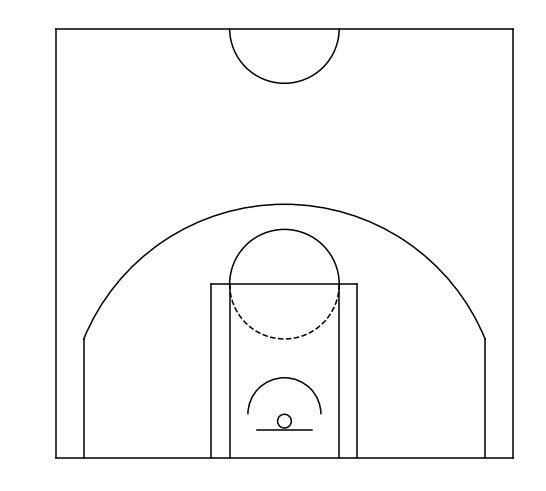

In [27]:
court, court_axis = draw_court()
court

The coordinate system returned from the `shotchartdetail` endpoint has its origin at the basket and the units of each cooridndate are feet times 10 (description [here](https://rdrr.io/github/llefebure/nba-stats/man/courtOutline.html)). For example, a 10 foot shoot from straight on would be taken from `LOC_X = 0` and `LOC_Y = 100`. Additionally, the reported `LOC_X` locations are flipped with negative values of `LOC_X` corresponding to the left side of the basket if facing it from the court. The court visual above has negative values of `LOC_X` corresponding to the right side of the basket if facing it from the court. To adjust for this, we can flip the sign on all `LOC_X` values.

In [28]:
def plot_shot(shot):
    """ plot_shot plots a shot or list of shots given in the
    shot DataFrame provided

    @param shot (DataFrame): DataFrame of shots with LOC_X and
        LOC_Y columns

    Returns

        court (maplotlib.figure.Figure): Court visual with
            the shots plotted
    """
    court, court_axis = draw_court()
    miss_df = shot[shot['SHOT_MADE_FLAG']==0]
    make_df = shot[shot['SHOT_MADE_FLAG']==1]

    if len(make_df)>0:
        court_axis.plot(-make_df['LOC_X'], make_df['LOC_Y'], 'ko')
    if len(miss_df)>0:
        court_axis.plot(-miss_df['LOC_X'], miss_df['LOC_Y'], 'kx')

    plt.close()
    return court

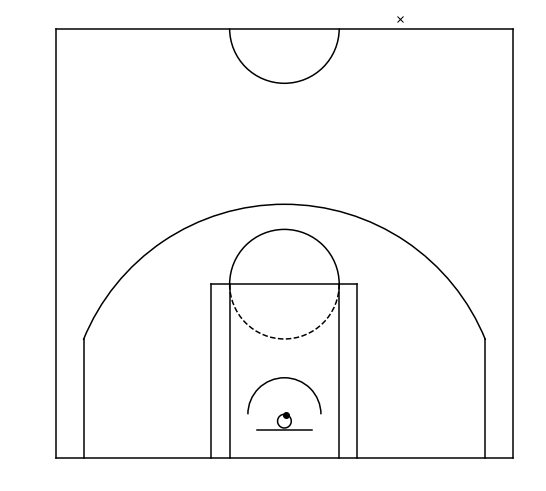

In [29]:
plot_shot(all_shots_df.loc[[178745, 34419]])

The above chart shows two shots, one with a 97% make probability (marked with a dot) and another with a 5% make probability (marked with an x). Again, this serves as a visualization to confirm that the model performs well in the extremes. A heatmap will allow for an examination of model performance from all areas. The function below, `model_heatmap`, plots the make probability of a given shot type from all locations in the halfcourt.

In [30]:
def model_heatmap(shot_type, shot_model):
    """ model_heatmap plots the make probability
    of a given shot_type from all relevant locations.

    @param shot_type (str): Shot type equal to one
        of 'DUNK', 'LAYUP', 'HOOK', or 'JUMP'

    @param shot_model (sklearn.ensemble.forest.RandomForestClassifier):
        Shot probability model
    Returns:

        heatmap (maplotlib.figure.Figure): Court visual with
            the heatmap plotted
    """

    if shot_type == 'JUMP':
        x_vals = list(range(-250, 250, 3))
        y_vals = list(range(0, 430, 3))
    else:
        x_vals = list(range(-100, 100, 1))
        y_vals = list(range(0, 100, 1))

    coordinate_vals = list(itertools.product(x_vals, y_vals))

    model_df = pd.DataFrame(coordinate_vals, columns=['LOC_X', 'LOC_Y'])
    model_df['SHOT_DISTANCE'] = np.sqrt((model_df['LOC_X']/10.0)**2 + (model_df['LOC_Y']/10.0)**2)
    if shot_type != 'JUMP':
        model_df = model_df[model_df['SHOT_DISTANCE']<=10]

    model_df['ANGLE'] = abs(np.rad2deg(np.arctan2(model_df['LOC_X'],
                                                  model_df['LOC_Y'])))

    model_df['SIDE'] = [1 if x >= 0 else 0 for x in model_df['LOC_X']]
    for shot_types in ['DUNK', 'LAYUP', 'HOOK', 'JUMP']:
        if shot_type == shot_types:
            model_df[shot_types] = [1]*len(model_df)
        else:
            model_df[shot_types] = [0]*len(model_df)

    features_df = model_df[['SHOT_DISTANCE', 'ANGLE', 'SIDE', 'DUNK', 'HOOK', 'LAYUP', 'JUMP']]
    model_test_preds = shot_model.predict_proba(features_df)
    model_df['shot_prob'] = [x[1] for x in model_test_preds]

    heatmap, heatmap_axis = draw_court()

    hm = heatmap_axis.scatter(-model_df['LOC_X'], model_df['LOC_Y'],
                              c=model_df['shot_prob'], cmap='coolwarm', vmin=0, vmax=1)
    cbar = heatmap.colorbar(hm)
    cbar.set_clim(vmin=0, vmax=1)
    cbar.set_label(label='Shot Probability', fontsize=14)
    plt.title(shot_type.title() + ' Shot Probability', fontsize=14)
    plt.close()
    return heatmap

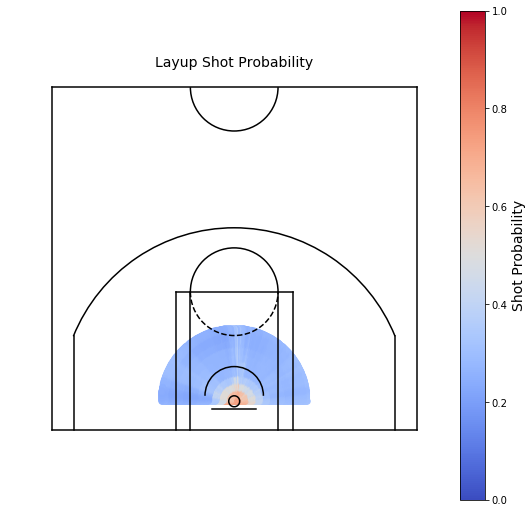

In [31]:
model_heatmap('LAYUP', rf_best)

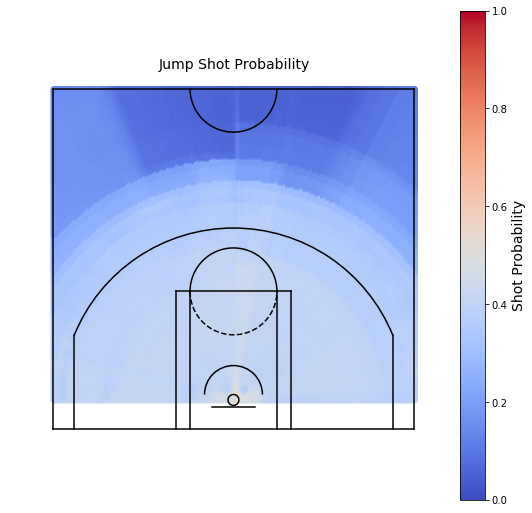

In [32]:
model_heatmap('JUMP', rf_best)

The above two charts reveal the nuance captured by the shot probability model. For a jump shot, the probability of making a shot decreases gradually as the distance from the basket increases. This provides credence to the three-point field goal revolution as the gradual decrease in shot probability is overcome by the increased value of a three-point field goal. A sharp decline in shot probability occurs well beyond the three-point line according to this model. For a layup, the probability of making a shot drops precipitously beyond the immediate vicinity of the hoop.

## Shot Videos

What better way to explore a shot probability model than to view videos of the actual shots? The code below predicts the shot probability for all shots available, and then prints the URL for particularly interesting shots.

In [59]:
all_preds = rf_best.predict_proba(features_df)
all_preds = [x[1] for x in all_preds]
all_shots_df['shot_prob'] = all_preds

In [60]:
all_shots_df.sort_values('shot_prob')

,ACTION_TYPE,EVENT_TYPE,GAME_DATE,GAME_EVENT_ID,GAME_ID,GRID_TYPE,HTM,LOC_X,LOC_Y,MINUTES_REMAINING,...,TEAM_ID,TEAM_NAME,VTM,ANGLE,SIDE,DUNK,HOOK,LAYUP,JUMP,shot_prob
131890,Jump Shot,Missed Shot,20190128,143,21800744,Shot Chart Detail,CHA,-40,535,0,...,1610612766,Charlotte Hornets,NYK,4.275841,0,0,0,0,1,0.042688
81508,Jump Shot,Missed Shot,20181219,437,21800460,Shot Chart Detail,CHI,-38,516,0,...,1610612751,Brooklyn Nets,BKN,4.211853,0,0,0,0,1,0.042753
124931,Jump Bank Shot,Missed Shot,20190122,538,21800704,Shot Chart Detail,DAL,-33,468,0,...,1610612742,Dallas Mavericks,LAC,4.033411,0,0,0,0,1,0.043053
75723,Pullup Jump shot,Missed Shot,20181214,446,21800427,Shot Chart Detail,POR,-37,487,0,...,1610612757,Portland Trail Blazers,TOR,4.344721,0,0,0,0,1,0.043201
194696,Pullup Jump shot,Missed Shot,20190323,341,21801094,Shot Chart Detail,SAC,-31,472,0,...,1610612758,Sacramento Kings,PHX,3.757673,0,0,0,0,1,0.043542
33764,Running Jump Shot,Missed Shot,20181112,294,21800190,Shot Chart Detail,WAS,-118,504,0,...,1610612753,Orlando Magic,ORL,13.177140,0,0,0,0,1,0.043848
53361,Jump Shot,Missed Shot,20181126,478,21800300,Shot Chart Detail,GSW,-46,572,0,...,1610612744,Golden State Warriors,ORL,4.597808,0,0,0,0,1,0.043851
110983,Jump Shot,Missed Shot,20190111,515,21800626,Shot Chart Detail,MIN,-44,509,0,...,1610612742,Dallas Mavericks,DAL,4.940595,0,0,0,0,1,0.043858
210308,Jump Shot,Missed Shot,20190405,46,21801181,Shot Chart Detail,ORL,-32,520,8,...,1610612737,Atlanta Hawks,ATL,3.521453,0,0,0,0,1,0.043927
40639,Jump Shot,Missed Shot,20181117,337,21800229,Shot Chart Detail,BOS,-29,510,0,...,1610612762,Utah Jazz,UTA,3.254491,0,0,0,0,1,0.043927


### Highest Probability Missed Shot

In [64]:
all_shots_df[all_shots_df['SHOT_MADE_FLAG']==0].sort_values('shot_prob').tail(2)

,ACTION_TYPE,EVENT_TYPE,GAME_DATE,GAME_EVENT_ID,GAME_ID,GRID_TYPE,HTM,LOC_X,LOC_Y,MINUTES_REMAINING,...,TEAM_ID,TEAM_NAME,VTM,ANGLE,SIDE,DUNK,HOOK,LAYUP,JUMP,shot_prob
44915,Running Dunk Shot,Missed Shot,20181121,362,21800253,Shot Chart Detail,PHI,5,8,2,...,1610612755,Philadelphia 76ers,NOP,32.005383,1,1,0,0,0,0.968525
214076,Cutting Dunk Shot,Missed Shot,20190407,571,21801201,Shot Chart Detail,MEM,-2,7,6,...,1610612763,Memphis Grizzlies,DAL,15.945396,0,1,0,0,0,0.968947


In [65]:
print('https://stats.nba.com/events/?flag=1&GameID=00{game_id}&GameEventID={event_id}&Season=2018-19&sct=plot'.format(game_id=21800253,
                                                                                                                      event_id=362))

https://stats.nba.com/events/?flag=1&GameID=0021800253&GameEventID=362&Season=2018-19&sct=plot


### Lowest Probability Made Shot

The first two shots either have missing video or erroneous data.

In [66]:
all_shots_df[all_shots_df['SHOT_MADE_FLAG']==1].sort_values('shot_prob').head(1)

,ACTION_TYPE,EVENT_TYPE,GAME_DATE,GAME_EVENT_ID,GAME_ID,GRID_TYPE,HTM,LOC_X,LOC_Y,MINUTES_REMAINING,...,TEAM_ID,TEAM_NAME,VTM,ANGLE,SIDE,DUNK,HOOK,LAYUP,JUMP,shot_prob
187632,Pullup Jump shot,Made Shot,20190318,152,21801055,Shot Chart Detail,SAS,29,603,0,...,1610612744,Golden State Warriors,GSW,2.753397,1,0,0,0,1,0.045884


In [67]:
print('https://stats.nba.com/events/?flag=1&GameID=00{game_id}&GameEventID={event_id}&Season=2018-19&sct=plot'.format(game_id=21801055,
                                                                                                                      event_id=152))

https://stats.nba.com/events/?flag=1&GameID=0021801055&GameEventID=152&Season=2018-19&sct=plot


## Exploration

- This notebook mentions several other factors that affect shot probability but are not included in the model. Can you name more or incorporate them in a better model?
- This exercise contained several modeling assumptions, including the feature engineering choices and using a random forest model. Challenge one of these assumptions to take the analysis further.